In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
ls

drive/  sample_data/


In [2]:
cd drive/MyDrive/Face_Mask/

/content/drive/MyDrive/Face_Mask


In [3]:
# USAGE
# python train_mask_detector.py --dataset dataset

# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os

In [8]:

# # construct the argument parser and parse the arguments
# ap = argparse.ArgumentParser()
# ap.add_argument("-d", "--dataset", required=True,
# 	help="path to input dataset")
# ap.add_argument("-p", "--plot", type=str, default="plot.png",
# 	help="path to output loss/accuracy plot")
# ap.add_argument("-m", "--model", type=str,
# 	default="mask_detector.model",
# 	help="path to output face mask detector model")
# args = vars(ap.parse_args())


usage: ipykernel_launcher.py [-h] -d DATASET [-p PLOT] [-m MODEL]
ipykernel_launcher.py: error: the following arguments are required: -d/--dataset


SystemExit: ignored

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2890: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [4]:

# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

In [5]:
import os
from os import listdir

In [14]:
ls

app.py                images/              Readme_images/
CODE_OF_CONDUCT.md    LICENSE              README.md
dataset/              license.txt          requirements.txt
detect_mask_image.py  mask_detector.model  search.py
detect_mask_video.py  plot.png             train_mask_detector.py
face_detector/        __pycache__/         Untitled.ipynb


In [8]:
imagePaths_with = listdir('dataset/with_mask')
imagePaths_without = listdir('dataset/without_mask')
print(len(imagePaths_wio),len(imagePaths_with))

1935 1949


In [9]:
print(imagePaths_with)
print(imagePaths_without)

['2.jpg', '0_0_≈˙◊¢ 2020-02-24 225427.png', 'black22.jpg', '15.jpg', '176.jpg', '22.jpg', '288.jpg', '0_1_20.jpg', 'with_mask001.jpg', '1_0_3 copy 7.jpg', '0_1_0.jpg', '1_0_3 2.jpg', '0_2_ab41fce2gy1fyq9sp8l7rj223u35sx6p.jpg', '254.jpg', 'black2.jpg', '6.jpg', '0_1_19.jpg', '133.jpg', '0_0_œ¬‘ÿ.png', '0_0_≈˙◊¢ 2020-02-24 215234.png', '299.jpg', '257.jpg', '184.jpg', '0_1_48.jpg', '1_0_0 copy.jpeg', '1_0_33.jpg', '182.jpg', 'with_mask006.jpg', '1_0_5 copy 3.jpg', '0_1_1.jpg', '0_1_24 copy.jpg', 'black17.jpg', '54.jpg', '0_0_≈˙◊¢ 2020-02-25 185823.png', '1_0_10 copy 2.jpg', '97.jpg', '1_0_19 copy.jpg', '0_1_0 copy 2.jpg', '1_0_2 copy.jpg', '324.jpg', '209.jpg', '30.jpg', '0_1_5.jpg', '1_0_9de50022gy1fkizdl3o16j22kw3vcu12.jpg', '41.jpg', '1_0_0 copy 9.jpg', '84.jpg', '0_1_2 copy.jpg', '56.jpg', '82.jpg', '14.jpg', '115.jpg', '242.jpg', '322.jpg', '0_1_18 copy 3.jpg', '0_1_6.jpg', '148.jpg', '235.jpg', '53.jpg', '206.jpg', '1_1_663d85a4jw6dd814u9pyfj.jpg', '325.jpg', '1_0_15 copy 3.jpg', 

In [12]:
# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")
#imagePaths = list(paths.list_images(args["/content/drive/MyDrive/Face_Mask/dataset"]))
# imagePaths = 
data = []
labels = []


[INFO] loading images...


In [13]:
i = 0
# loop over the image paths
for imagePath in imagePaths_without:
  # extract the class label from the filename
  label = 'without'
  print(i)
  i += 1
  imagePath = 'dataset/without_mask/' + imagePath
  # load the input image (224x224) and preprocess it
  image = load_img(imagePath, target_size=(224, 224))
  image = img_to_array(image)
  image = preprocess_input(image)

  # update the data and labels lists, respectively
  data.append(image)
  labels.append(label)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [15]:
i=0
# loop over the image paths
for imagePath in imagePaths_with:
  # extract the class label from the filename
  label = 'with'
  imagePath = 'dataset/with_mask/' + imagePath
  print(i)
  i += 1
  # load the input image (224x224) and preprocess it
  image = load_img(imagePath, target_size=(224, 224))
  image = img_to_array(image)
  image = preprocess_input(image)

  # update the data and labels lists, respectively
  data.append(image)
  labels.append(label)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
600
601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696
697
698
699
700
701
702
703
704
705
706
707
708
709
710
711
712
713
714
715
716
717
718
719
720
721
722
723
724
725
726
727
728
729
730
731
732
733
734
735
736
737
738
739
740
741
742
743
744
745
746
747
748
749
750
751
752
753
754
755
756
757
758
759
760
761
762
763
764
765
766
767
768
769
770
771
772
773
774
775
776
777
778
779
780
781
782
783
784
785
786
787
788
789
790
791
792
793
794
795
796
797
798
799
800
801
802
803
804
805
806
807
808
809
810
811
812
813
814
815
816
817
818
819
820
821
822


In [21]:
print(len(labels))

3884


In [22]:


# convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)

# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)


In [24]:
print(labels)

[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [25]:

# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

9412608/9406464 [==============================] - 0s 0us/step


In [26]:


# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

# train the head of the network
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

[INFO] compiling model...
[INFO] training head...
Epoch 1/20
97/97 [==============================] - 40s 329ms/step - loss: 0.6347 - accuracy: 0.6953 - val_loss: 0.1907 - val_accuracy: 0.9653
Epoch 2/20
97/97 [==============================] - 31s 319ms/step - loss: 0.1757 - accuracy: 0.9639 - val_loss: 0.1324 - val_accuracy: 0.9614
Epoch 3/20
97/97 [==============================] - 31s 318ms/step - loss: 0.1256 - accuracy: 0.9657 - val_loss: 0.0918 - val_accuracy: 0.9730
Epoch 4/20
97/97 [==============================] - 31s 319ms/step - loss: 0.0938 - accuracy: 0.9724 - val_loss: 0.0752 - val_accuracy: 0.9768
Epoch 5/20
97/97 [==============================] - 31s 318ms/step - loss: 0.0758 - accuracy: 0.9774 - val_loss: 0.0646 - val_accuracy: 0.9781
Epoch 6/20
97/97 [==============================] - 31s 319ms/step - loss: 0.0576 - accuracy: 0.9841 - val_loss: 0.0700 - val_accuracy: 0.9755
Epoch 7/20
97/97 [==============================] - 31s 317ms/step - loss: 0.0639 - accuracy

[INFO] evaluating network...
              precision    recall  f1-score   support

        with       0.97      0.99      0.98       390
     without       0.99      0.97      0.98       387

    accuracy                           0.98       777
   macro avg       0.98      0.98      0.98       777
weighted avg       0.98      0.98      0.98       777



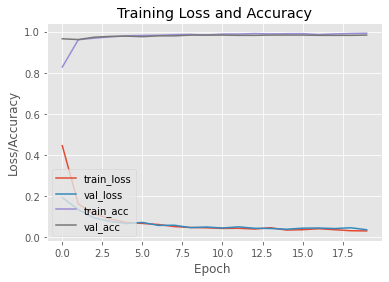

In [32]:


# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

# serialize the model to disk
# print("[INFO] saving mask detector model...")
# model.save(args["model"], save_format="h5")

# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch ")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
#plt.savefig(args["plot"])
